# Hyperparameter optimization with Dask


Every machine learning model has some values that are specified before training begins. These values help adapt the model to the data but must be given before any training data is seen. For example, this might be `penalty` or `C` in Scikit-learn's [LogisiticRegression]. These values that come before any training data and are called "hyperparameters". Typical usage looks something like:

``` python
from sklearn.linear_model import LogisiticRegression
from sklearn.datasets import make_classification

X, y = make_classification()
est = LogisiticRegression(C=10, penalty="l2")
est.fit(X, y)
```

These hyperparameters influence the quality of the prediction. If `C` is too small above, the output of the estimator will be too regularized to produce meaningful output.

Determining the values of these hyperparameters is difficult. In fact, Scikit-learn has an entire documentation page on finding the best values: https://scikit-learn.org/stable/modules/grid_search.html

[LogisiticRegression]:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


Dask enables some new techniques and opportunities for hyperparameter optimization. These opportunities involve stopping training early to limit computation (naturally, this requires a `partial_fit` or `warm_start` implementation in Scikit-learn parlance).

**This notebook will walk through**

* setting up a realistic example
* how to use `HyperbandSearchCV`, including
    * how to determine the inputs
    * how to access informantion from `HyperbandSearchCV`
    
This notebook will specifically *not* show a performance comparison motivating `HyperbandSearchCV` use. `HyperbandSearchCV` finds high scores with minimal training; however, this is a tutorial on how to *use* it. All performance comparisons are relegated to section [*Learn more*](#Learn-more).

In [1]:
%matplotlib inline

# Setup Dask

In [2]:
from distributed import Client
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Client Scheduler: inproc://192.168.7.20/20370/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


## Create Data

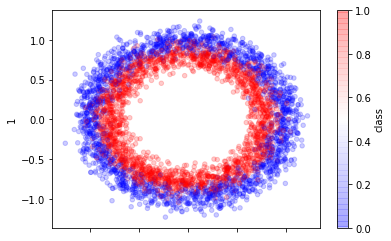

In [3]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd

X, y = make_circles(n_samples=30_000, random_state=0, noise=0.09)

pd.DataFrame({0: X[:, 0], 1: X[:, 1], "class": y}).sample(4_000).plot.scatter(
    x=0, y=1, alpha=0.2, c="class", cmap="bwr"
);

### Add random dimensions

In [4]:
from sklearn.utils import check_random_state

rng = check_random_state(42)
random_feats = rng.uniform(-1, 1, size=(X.shape[0], 4))
X = np.hstack((X, random_feats))
X.shape

(30000, 6)

### Split and scale data

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5_000, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Create model and search space

Let's use Scikit-learn's MLPClassifier as our model (for convenience). Let's use this model with 24 neurons and tune some of the other basic hyperparameters.


In [7]:
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

Deep learning libraries can be used as well. In particular, [PyTorch]'s Scikit-Learn wrapper [Skorch] works well with `HyperbandSearchCV`.

[PyTorch]:https://pytorch.org/
[Skorch]:https://skorch.readthedocs.io/en/stable/

In [8]:
params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [16, 32, 64, 128, 256, 512],
}

# Hyperparameter optimization

`HyperbandSearchCV` is Dask-ML's meta-estimator to find the best hyperparameters. It can be used as an alternative to `RandomizedSearchCV` to find similar hyper-parameters in less time by not wasting time on hyper-parameters that are not promising. Specifically, it is almost guaranteed that it will find high performing models with minimal training.

This section will focus on

1. Determining the input parameters to `HyperbandSearchCV`
2. Using `HyperbandSearchCV` to find the best hyperparameters
3. Seeing other use cases of `HyperbandSearchCV`

In [9]:
from dask_ml.model_selection import HyperbandSearchCV

## Determining input parameters

A rule-of-thumb to determine `HyperbandSearchCV`'s input parameters requires knowing:

1. the number of examples the longest trained model will see
2. the number of hyperparameters to evaluate

In [10]:
# For quick response
n_examples = 9 * len(X_train)
n_params = 9

# In practice, HyperbandSearchCV is most useful for longer searches
# n_examples = 27 * len(X_train)
# n_params = 27

With this, the inputs to `HyperbandSearchCV` fall out pretty naturally:

In [11]:
max_iter = n_params  # number of times partial_fit will be called
chunks = n_examples // n_params  # number of examples each call sees

max_iter, chunks

(9, 25000)

This means that the longest trained estimator will see about `n_examples` examples (specifically `n_params * (n_examples // n_params`).

`HyperbandSearchCV` will work by calling `partial_fit` on each chunk of a Dask array. The `max_iter` property determines how many times to call `partial_fit`:

In [12]:
search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    patience=True,
)

And the Dask array should be rechunked to determine how many examples each `partial_fit` call sees:

In [13]:
import dask.array as da
X_train = da.from_array(X_train, chunks=chunks)
y_train = da.from_array(y_train, chunks=chunks)
X_train.chunks

((25000,), (6,))

It isn't clear how to determine how much computation is done from `max_iter` and `chunks`. Luckily, `HyperbandSearchCV` has a `metadata` attribute to determine this beforehand:

In [14]:
search.metadata["partial_fit_calls"]

69

This shows how many `partial_fit` calls will be performed in the computation. `metadata` also includes information on the number of models created.

Now, let's do the model selection search and find the best hyperparameters.

In [15]:
%%time
search.fit(X_train, y_train, classes=[0, 1, 2, 3])

CPU times: user 21.2 s, sys: 4.13 s, total: 25.3 s
Wall time: 16.7 s


HyperbandSearchCV(aggressiveness=3,
                  estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_fun=15000, max_iter=200,
                                          momentum=0.9, n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          random_stat...
       9.26759330e-04, 9.33189772e-04, 9.39664831e-04, 9.46184819e-04,
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181

The dashboard will be active while this is running. It will show which workers are running `partial_fit` and `score` calls.

# Integration

`HyperbandSearchCV` follows the Scikit-learn API and mirrors Scikit-learn's `RandomizedSearchCV`. This means that it "just works". All the Scikit-learn attributes and methods are available:

In [16]:
search.best_score_

0.8606

In [17]:
search.best_estimator_

MLPClassifier(activation='relu', alpha=6.51349094627281e-05, batch_size=16,
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(24,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [18]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.head()

,rank_test_score,param_batch_size,test_score,mean_partial_fit_time,param_activation,std_score_time,std_partial_fit_time,param_alpha,bracket,model_id,params,param_hidden_layer_sizes,mean_score_time,partial_fit_calls
0,3,512,0.5106,0.480425,logistic,0.003545,0.073892,0.000723,2,bracket=2-0,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...","(12, 6, 3, 3)",0.012232,3
1,3,64,0.5106,1.002637,tanh,0.000000,0.000000,0.000298,2,bracket=2-1,"{'hidden_layer_sizes': (24,), 'batch_size': 64...","(24,)",0.013174,1
2,9,512,0.0000,0.344522,relu,0.000000,0.000000,0.000001,2,bracket=2-2,"{'hidden_layer_sizes': (12, 12), 'batch_size':...","(12, 12)",0.011708,1
3,7,64,0.4894,1.391385,relu,0.000000,0.000000,0.000104,2,bracket=2-3,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...","(12, 6, 3, 3)",0.009128,1
4,1,16,0.8462,0.863178,relu,0.004937,0.138913,0.000123,2,bracket=2-4,"{'hidden_layer_sizes': (12, 12), 'batch_size':...","(12, 12)",0.012497,9


In [19]:
search.score(X_test, y_test)

0.8574

In [20]:
search.predict(X_test)

dask.array<_predict, shape=(5000,), dtype=int64, chunksize=(5000,), chunktype=numpy.ndarray>

In [21]:
search.predict(X_test).compute()

array([1, 0, 1, ..., 1, 0, 0])

It also has some other attributes.

In [22]:
hist = pd.DataFrame(search.history_)
hist.head()

,model_id,params,partial_fit_calls,partial_fit_time,score,score_time,elapsed_wall_time,bracket
0,bracket=0-0,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",1,0.752126,0.5026,0.035058,2.120332,0
1,bracket=0-1,"{'hidden_layer_sizes': (24,), 'batch_size': 16...",1,0.697118,0.6836,0.020343,2.120335,0
2,bracket=0-2,"{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",1,0.335627,0.3476,0.013044,2.120336,0
3,bracket=1-0,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,0.299076,0.4322,0.015393,3.074187,1
4,bracket=1-1,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,1.476816,0.5014,0.012162,3.074189,1


This illustrates the history after every `partial_fit` call. There's also an attributed `model_history_` that records the history for each model (it's a reorganization of `history_`).

# Learn more

This notebook covered basic usage `HyperbandSearchCV`. The following documentation and resources might be useful to learn more about `HyperbandSearchCV`, including some of the finer use cases:

* [A talk](https://www.youtube.com/watch?v=x67K9FiPFBQ) introducing `HyperbandSearchCV` to the SciPy 2019 audience and the [corresponding paper](https://conference.scipy.org/proceedings/scipy2019/pdfs/scott_sievert.pdf)
* [HyperbandSearchCV's documentation](https://ml.dask.org/modules/generated/dask_ml.model_selection.HyperbandSearchCV.html)

Performance comparisons can be found in the SciPy 2019 talk/paper.